In [678]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import matplotlib.animation as animation
from matplotlib.patches import Circle

In [679]:
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

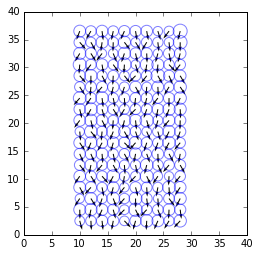

In [680]:
L = 40
N = 180
delta_theta = np.zeros(N)

x = np.array([10, 2.5]) + np.array([[2*(i%10), 2*np.floor(i/10)] for i in range(N)]) 
v = np.zeros([N, 2])
psi = -np.pi/2 * np.ones(N) + np.random.uniform(-np.pi/4, np.pi/4, N) 
radii = np.random.normal(1, 0.1, N)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, L])
ax.set_ylim([0, L])
ax.set_aspect(1)
plt.quiver(x[:, 0], x[:, 1], np.cos(psi), np.sin(psi), linewidths = 0.01)
circles(x[:,0], x[:, 1], radii, c='b',alpha=0.5, facecolor='none')
plt.show()

In [681]:
def compute_self_propulsion_force(N, psi):
    F_self = np.zeros([N, 2])
    F_self[:, 0] = np.cos(psi)    
    F_self[:, 1] = np.sin(psi)
    
    return F_self

def compute_repulsion_force(N, angles, overlap, k):
    d = np.zeros([N, N, 2])
    d[:, :, 0] = np.cos(angles) * overlap 
    d[:, :, 1] = np.sin(angles) * overlap 
    d = np.sum(d, axis=1)
   
    return k*d

def compute_boundary_force(N, theta_out, psi):
    F_boundary = np.zeros([N, 2])
    F_abs = 0.3 * (theta_out - np.pi) * (theta_out > np.pi)
    F_boundary[:, 0] = F_abs * np.cos(psi)
    F_boundary[:, 1] = F_abs * np.sin(psi)

    return F_boundary

def compute_align_torque(N, neighs, psi):
    delta_psi = (psi[None, :] - psi[:, None])*neighs
    delta_psi_sum = np.mod(np.sum(delta_psi, axis=1), 2*np.pi)
    delta_psi_sum[delta_psi_sum > np.pi] -= 2*np.pi
    
    return delta_psi_sum
    
def compute_angles(N, neighs, dist_components, psi):
    angles = np.arctan2(dist_components[:, :, 1], dist_components[:, :, 0])
    neigh_angles = neighs*angles
    
    delta_theta = np.zeros(N)
    theta_in = np.zeros(N)
    theta_out = np.zeros(N)
    
    for i in range(N):
        sorted_angles = np.sort(neigh_angles[i, :][np.nonzero(neigh_angles[i, :])])

        if not len(sorted_angles) > 0:
            continue          
            
        angles_difference = sorted_angles - np.roll(sorted_angles, 1) 
        angles_difference[angles_difference<0] += 2*np.pi
        max_index = np.argmax(angles_difference)
        
        if angles_difference[max_index] >= np.pi:
            theta_out[i] = np.abs(angles_difference[max_index])
            theta_in[i] = sorted_angles[max_index-1]  - (2*np.pi - theta_out[i])/2 
            delta_theta[i] = theta_in[i] - psi[i]
      
    return angles, delta_theta, theta_in, theta_out

def update(N, L, x, radii, psi):
    #    Compute distance vector between particles
    dist_components = x[None, :, :] - x[:, None, :]
    dist_components = dist_components - np.rint(dist_components/L)*L
    distances = np.linalg.norm(dist_components, axis = 2)
    
    #    Compute neighbours matrix. Entries are 0 if particles are not neighbours, 1 if they are
    neighs = np.zeros([N, N])
    neighs[(distances < 2.7) & (distances >0)] = 1
    
    #    Compute overlap matrix. Entries are 0 if particles don't overlap, 1 if they are
    overlap = np.zeros([N, N])
    radii_sum = radii[None, :] + radii[:, None]
    
    #    If the sum of the radii of the particles is smaller than their distance there is overlap
    overlap[distances - radii_sum < 0] = np.abs((distances - radii_sum)[distances - radii_sum < 0])
    np.fill_diagonal(overlap, 0)
    
    #    Compute angles between particles
    angles, delta_theta, theta_in, theta_out = compute_angles(N, neighs, dist_components, psi)
 
    #    Compute all forces
    F_self = compute_self_propulsion_force(N, psi)
    F_repulsion = compute_repulsion_force(N, angles, overlap, 1)
    F_boundary = compute_boundary_force(N, theta_out, psi)   
    F = 0.06*F_self + 3*F_boundary + F_repulsion
    
    #    Compute all torques
    T_boundary = (theta_in-psi) * (theta_out > np.pi)
    T_noise = np.random.choice((-1, 1), size=N)
    T_align = compute_align_torque(N, neighs, psi)
    T = T_boundary + np.sqrt(0.06)*T_noise + 0.67*T_align    
    
    #   Update positions and angles
    x += F
    x = np.mod(x, L)
    
    psi += T
    psi = np.mod(psi, 2*np.pi)
    psi[psi>np.pi] -= 2*np.pi

    return x, psi

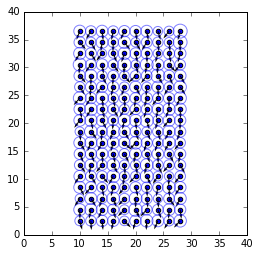

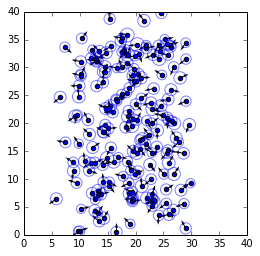

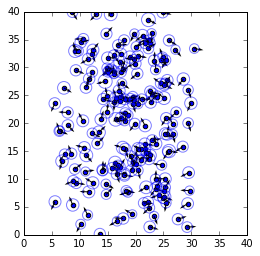

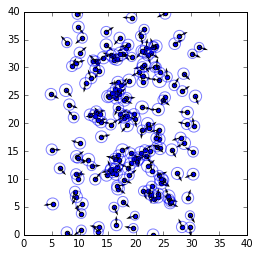

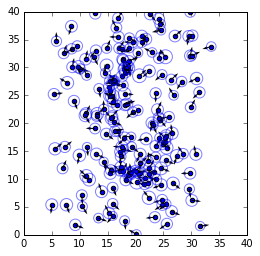

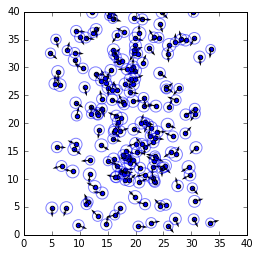

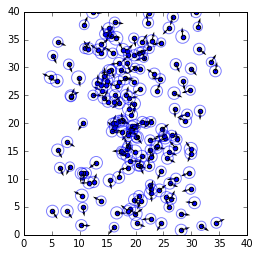

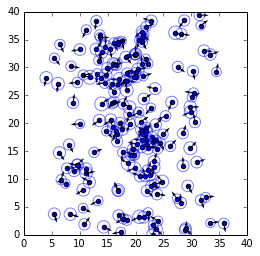

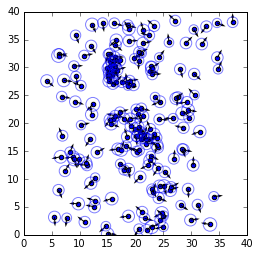

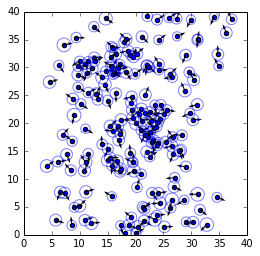

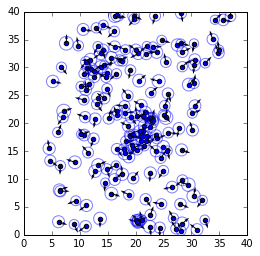

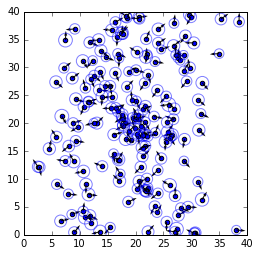

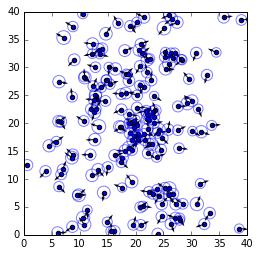

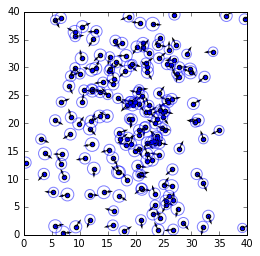

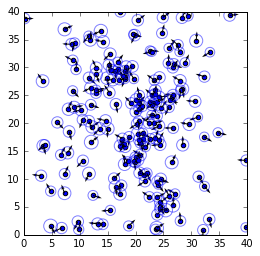

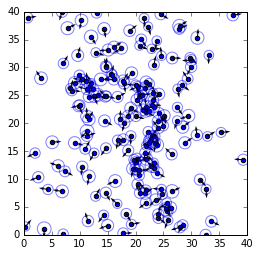

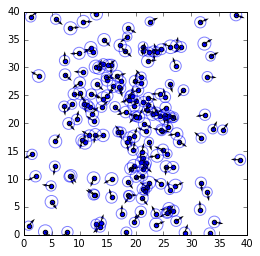

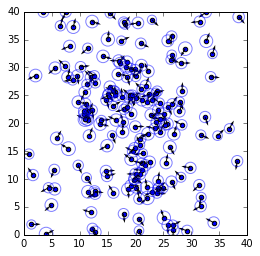

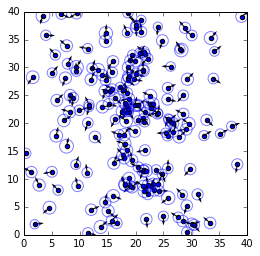

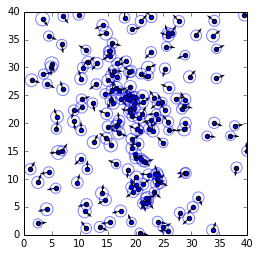

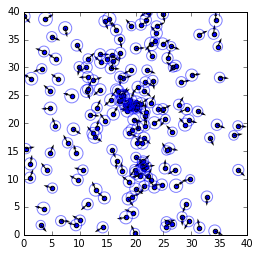

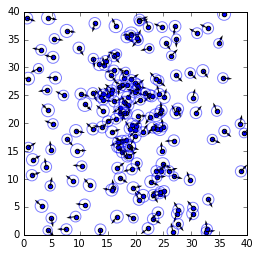

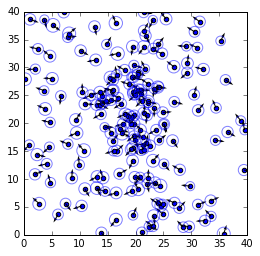

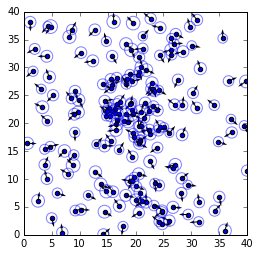

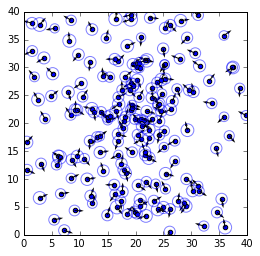

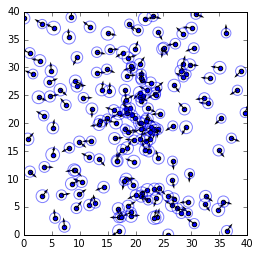

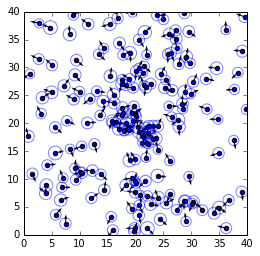

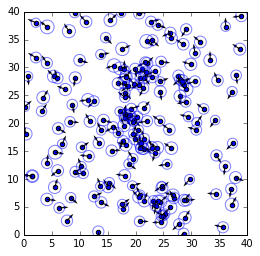

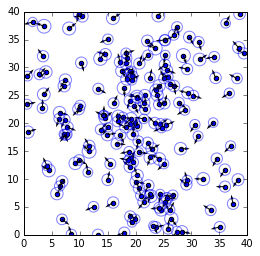

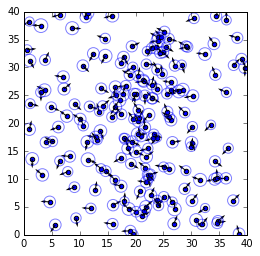

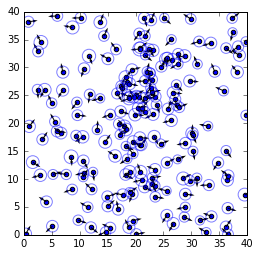

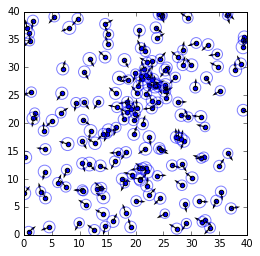

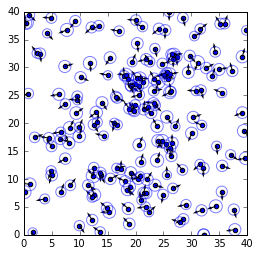

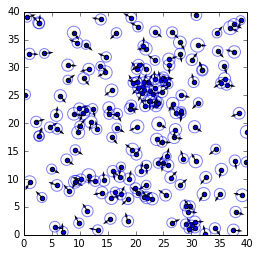

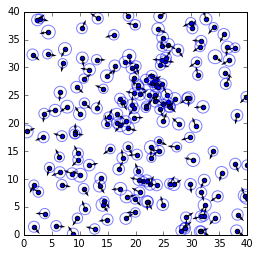

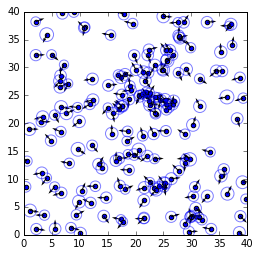

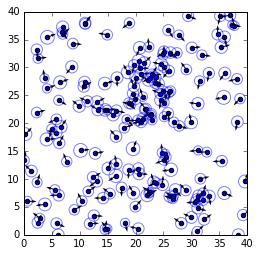

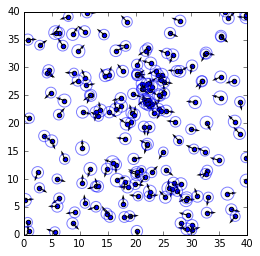

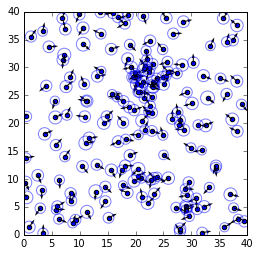

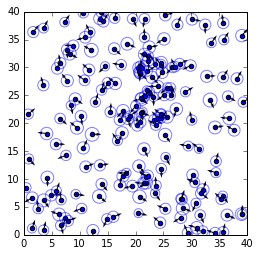

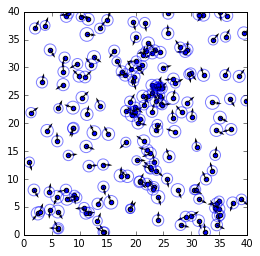

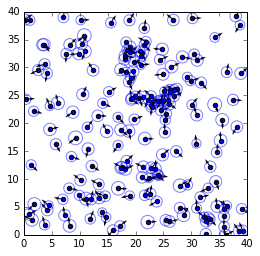

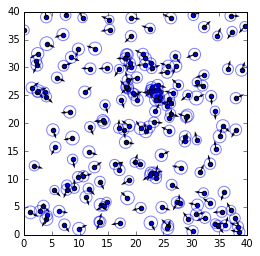

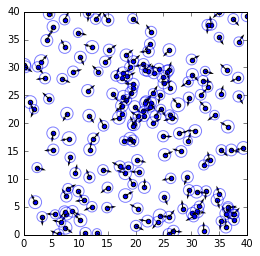

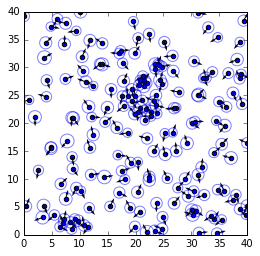

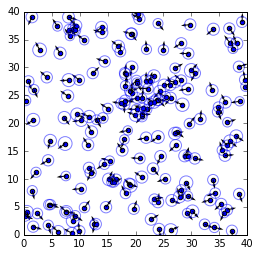

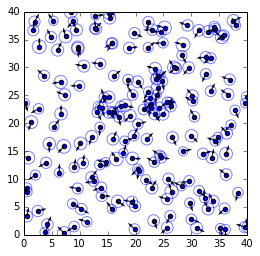

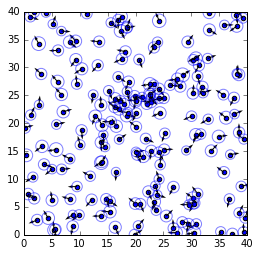

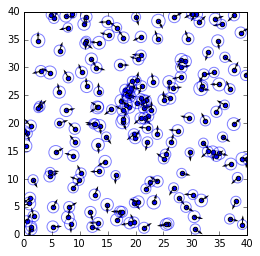

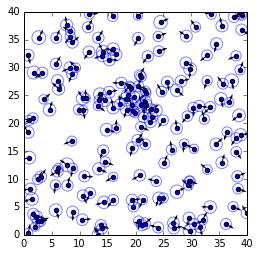

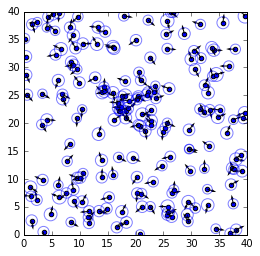

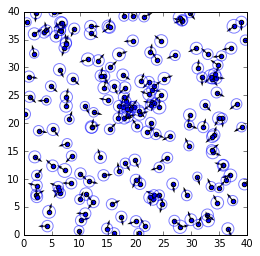

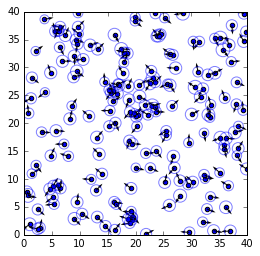

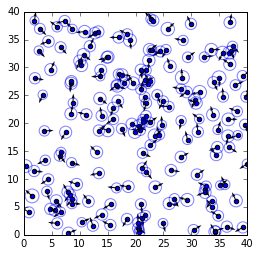

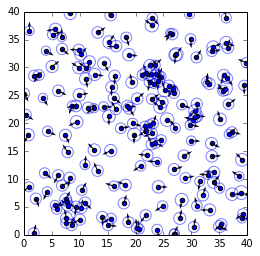

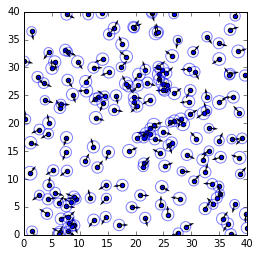

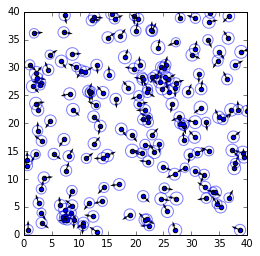

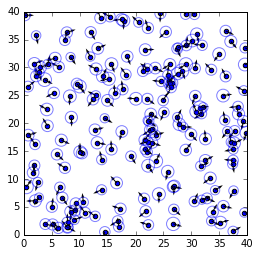

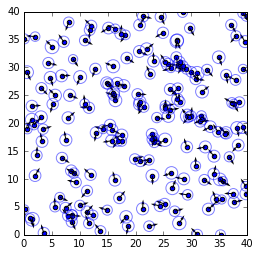

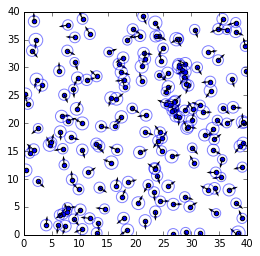

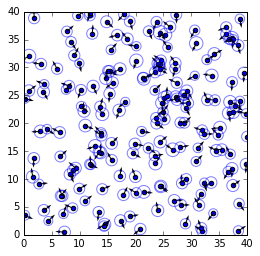

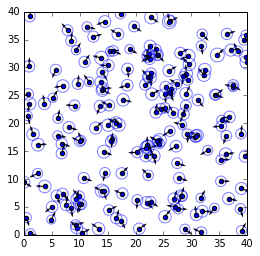

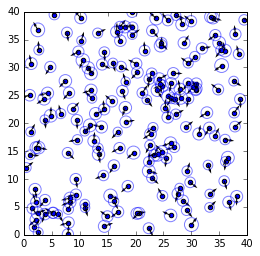

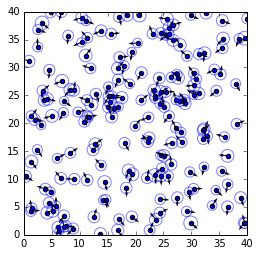

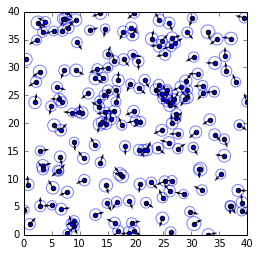

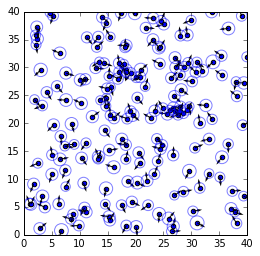

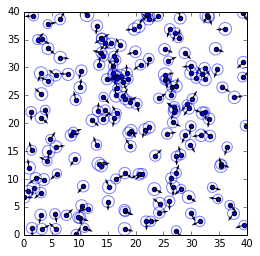

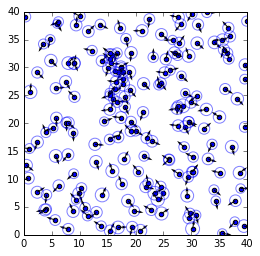

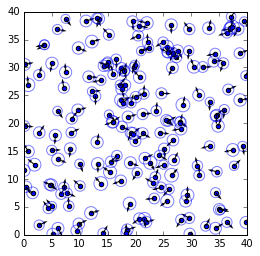

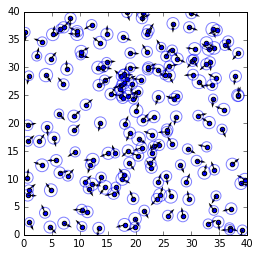

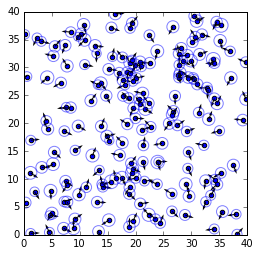

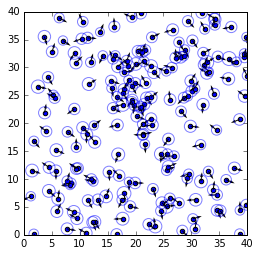

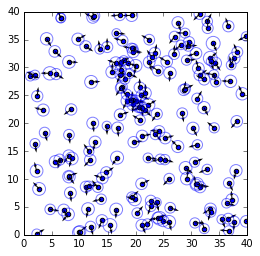

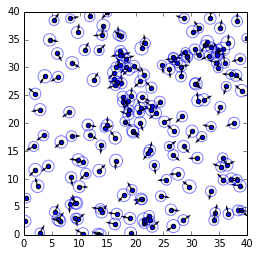

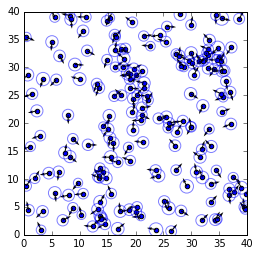

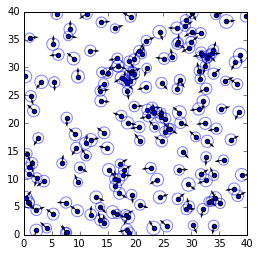

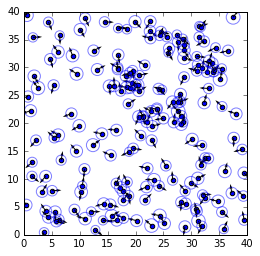

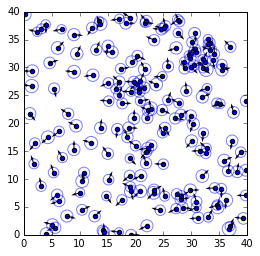

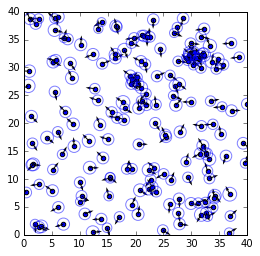

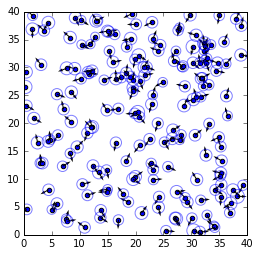

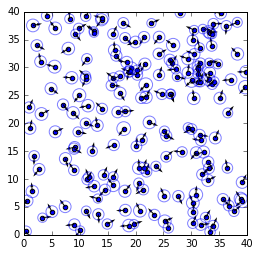

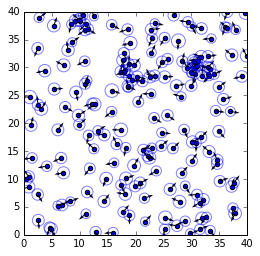

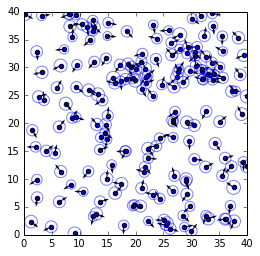

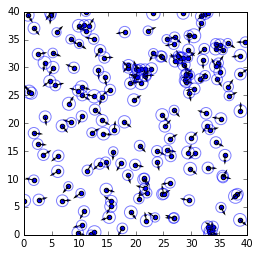

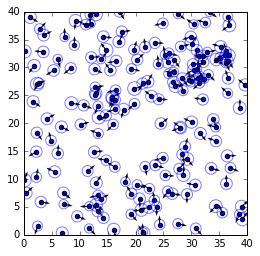

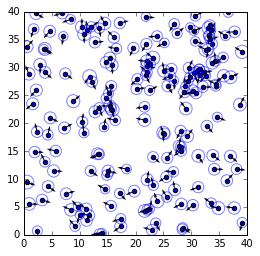

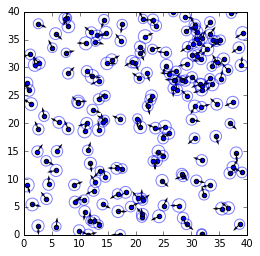

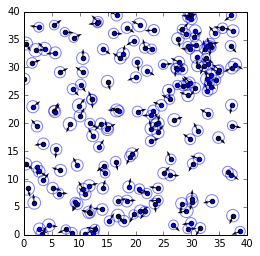

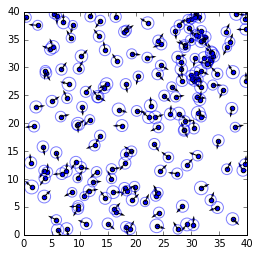

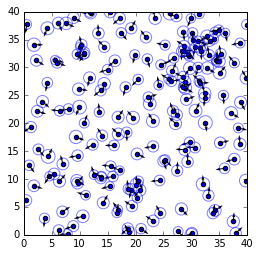

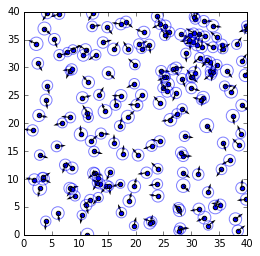

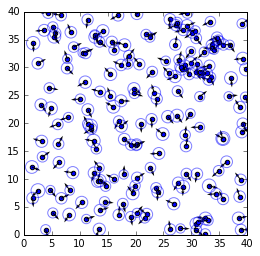

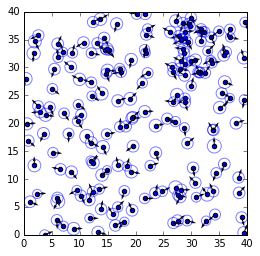

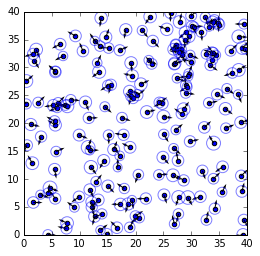

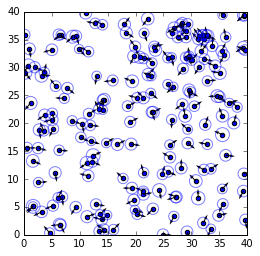

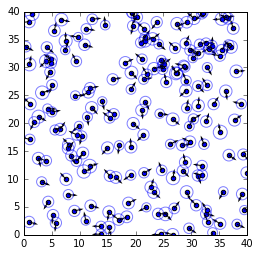

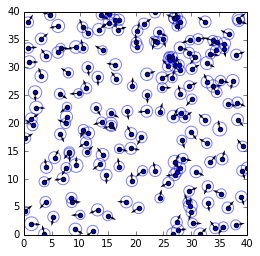

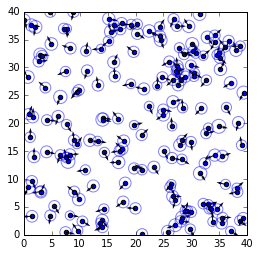

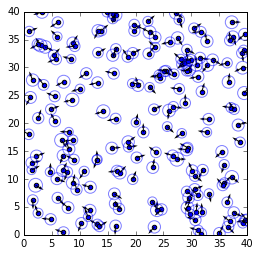

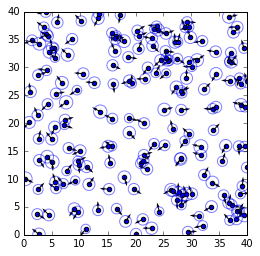

In [682]:
for i in range(1000):
    if i%10 == 0:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlim([0, L])
        ax.set_ylim([0, L])
        ax.set_aspect(1)
        plt.scatter(x[:, 0], x[:, 1])
        plt.quiver(x[:, 0], x[:, 1], np.cos(psi), np.sin(psi))  
        circles(x[:,0], x[:, 1], radii, c='b',alpha=0.5, facecolor='none')
        plt.show()
        
    x, psi = update(N, L, x, radii, psi)

